# https://www.kaggle.com/datasets/yasserh/walmart-dataset



Goal
===
1. Dowanload [Walmark dat from Kaggle](https://www.kaggle.com/datasets/yasserh/walmart-dataset)
2. work on Google drive with data
3. Learning three kind of Tree-based Model, xgboost, lightboost, catboost

- [Article](https://dataman-ai.medium.com/tree-based-xgb-lightgbm-and-catboost-models-for-multi-period-time-series-probabilistic-6b12d1500779)
- [Github Src](https://github.com/dataman-git/codes_for_articles/tree/master)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# clear the output 
import warnings
warnings.filterwarnings('ignore')

If runs on Google drive, we has to download the data anf upload it:
```
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/2023/2023-2-Python-AI/data'
```

In [3]:
# index by data, renamed as 'ds'
path='data'
#path='/content/gdrive/MyDrive/2023/2023-2-Python-AI/data'
data = pd.read_csv(path + '/Walmart.csv', delimiter=",")
data['ds'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.index = data['ds']
data = data.drop('Date', axis=1)
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
ds,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05


In [3]:
# $ data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Weekly_Sales  6435 non-null   float64       
 2   Holiday_Flag  6435 non-null   int64         
 3   Temperature   6435 non-null   float64       
 4   Fuel_Price    6435 non-null   float64       
 5   CPI           6435 non-null   float64       
 6   Unemployment  6435 non-null   float64       
 7   ds            6435 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 452.5 KB


In [6]:
!pip install -q darts

In [4]:
from darts import TimeSeries

In [7]:
darts_group_df[0].components

Index(['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object', name='component')

In [8]:
store1 = darts_group_df[0]
train = store1[:130]
test = store1[130:]
len(train), len(test) # (130, 13)

(130, 13)

In [9]:
target = train['Weekly_Sales']
past_cov = train[['Fuel_Price','CPI']]
future_cov = store1['Holiday_Flag'][:143]

In [5]:
darts_group_df = TimeSeries.from_group_dataframe(data, group_cols='Store', time_col='ds')
print("The number of groups/stores is:", len(darts_group_df))
print("The number of time period is: ", len(darts_group_df[0]))

The number of groups/stores is: 45
The number of time period is:  143


In [10]:
from darts.models import LightGBMModel
n = 12
model = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)


In [11]:
pred.values()

array([[1648229.14360717],
       [1647585.15388686],
       [1569763.01141598],
       [1627100.35048412],
       [1679217.5866184 ],
       [1711997.88579476],
       [1678208.72099501],
       [1731293.24264894],
       [1554316.24884006],
       [1692049.51861498],
       [1546896.79482908],
       [1510526.78395763]])

Mean Absolute Error: 77818.15743357211
Mean Absolute Percentage Error 5.094914261560658


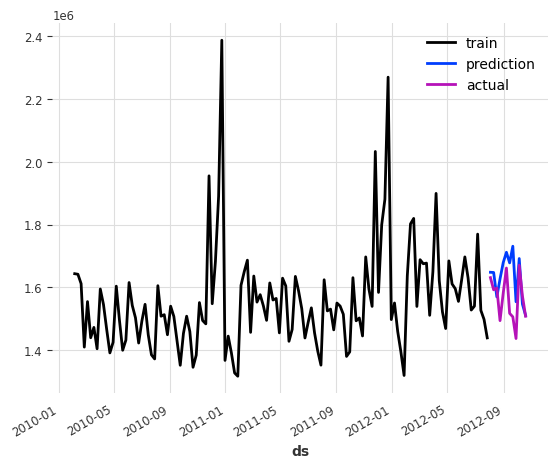

In [12]:
def plotit():
  import matplotlib.pyplot as plt
  target.plot(label = 'train')
  pred.plot(label = 'prediction')
  test['Weekly_Sales'][:n].plot(label = 'actual')

  from darts.metrics.metrics import mae, mape
  print("Mean Absolute Error:", mae(test['Weekly_Sales'][:n], pred))
  print("Mean Absolute Percentage Error", mape(test['Weekly_Sales'][:n], pred))

plotit()

In [13]:
n = 12
chunk_length = n
model = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)>
array([[[1593198.12521188, 2344904.86324741, 1577184.70005849,
         1747180.04800128, 1641308.76255625]],

       [[1554146.47535749, 1444187.59488855, 1780995.06652859,
         1536345.94594489, 1737020.85733302]],

       [[1778118.17449163, 1513492.90392872, 1516363.89558092,
         1501901.23812329, 1582293.49921   ]],

       [[1716320.80748962, 1397089.18151436, 1519889.74299773,
         1466057.59845214, 1541493.25515242]],

       [[1624164.34062585, 1587152.75201909, 1685782.31749414,
         1760546.2017698 , 1555450.99388072]],

       [[1768528.63041873, 1687972.6971626 , 1645196.19482581,
         1758163.3991611 , 1704940.31257109]],

       [[1764861.95816745, 1583243.00619796, 1573809.77490634,
         1660755.84761708, 1716616.75029181]],

       [[1483263.7780566 , 1575009.04049304, 1476764.77752111,
         1552728.9658958 , 1606150.09494595]],

       [[1595362.96613499, 1750983.02808351, 1517653.93496485,
         1562253.85575973, 1473337.58234805]],

       [[1791142.82909547, 1550889.43126414, 1452388.20111243,
         1535259.48038041, 1382434.84892679]],

       [[1520217.85538266, 1597615.38786403, 1559771.33435335,
         1557049.13833257, 1709420.92279977]],

       [[1485463.67338832, 1584091.54349767, 1493234.70203815,
         1474964.3057936 , 1459750.03276383]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

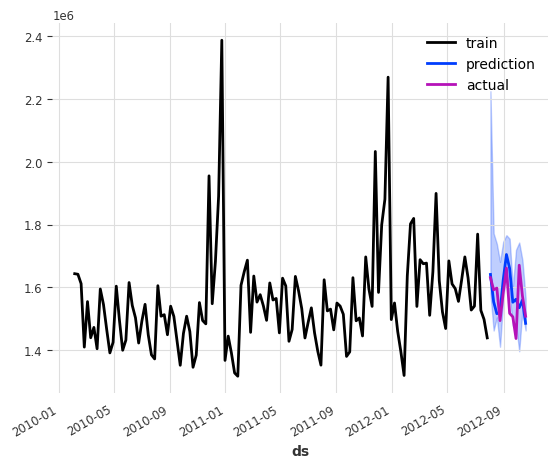

In [14]:
def plotQuantile():
    import matplotlib.pyplot as plt
    target.plot(label = 'train')
    pred.plot(label = 'prediction')
    test['Weekly_Sales'][:n].plot(label = 'actual')
plotQuantile()

In [15]:
from darts.models import XGBModel
n = 12
chunk_length = n
model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 1)>
array([[[1546996.4]],

       [[1653806. ]],

       [[1601980.8]],

       [[1677738.8]],

       [[1711640.6]],

       [[1682701.2]],

       [[1880154.4]],

       [[1860980.4]],

       [[2022899.8]],

       [[1649062.8]],

       [[1536916.8]],

       [[1450807.8]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

Mean Absolute Error: 158526.35583333333
Mean Absolute Percentage Error 10.553014098158657


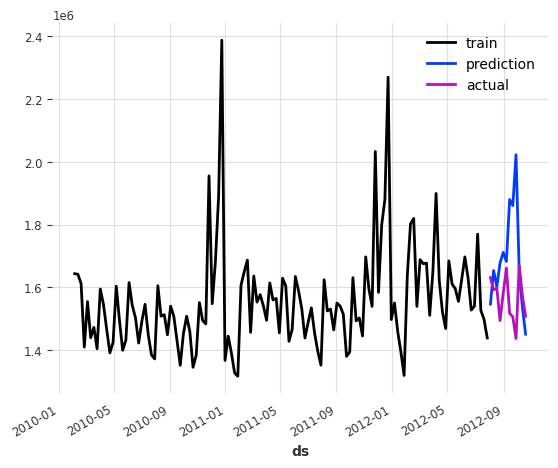

In [16]:
plotit()

In [17]:
from darts.models import XGBModel
n = 12
chunk_length = n
model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)>
array([[[1411327.31621186, 1521769.9139181 , 1654241.3131826 ,
         1526806.23658406, 1655441.00294302]],

       [[1614852.38479174, 1652978.84174624, 1584100.73079718,
         1629053.5603328 , 1516865.01304331]],

       [[1487781.3773196 , 2033435.        , 1508965.01075209,
         1561138.26375285, 1613030.24442357]],

       [[1476303.64138679, 1638287.24573904, 1536214.64398023,
         1639757.11527898, 1341221.5       ]],

       [[1699655.21514865, 1716919.6928741 , 1721551.92531879,
         1711557.52207953, 1699864.45094911]],

       [[1610707.93084613, 1500840.91760889, 1612348.11092423,
         1648860.93621363, 1490957.88644656]],

       [[1643888.08318466, 1751809.05169078, 1696132.85830033,
         1555458.28976543, 1439955.28690822]],

       [[1690649.44523534, 1653795.30115988, 1678933.5529745 ,
         1507572.45556945, 2033320.75      ]],

       [[1856946.75724432, 1452663.34877219, 1530108.48650138,
         1462264.02518228, 1345453.875     ]],

       [[1508689.91105352, 1408334.47916999, 1697423.23195349,
         1614330.82937373, 1696757.54802667]],

       [[1479234.61571319, 1384756.25206718, 1501014.94912558,
         1576704.27679261, 1613559.49778652]],

       [[1511955.64833543, 1485360.21932653, 1472728.45919013,
         1454149.10132383, 1460131.70871738]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

In [18]:
from darts.models import CatBoostModel
n = 12
chunk_length = n
model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 1)>
array([[[1623710.09296099]],

       [[1618556.92612083]],

       [[1638724.84930259]],

       [[1688493.45449343]],

       [[1687484.56592307]],

       [[1726272.91210104]],

       [[1662904.12539692]],

       [[1720962.0088489 ]],

       [[1685520.28526041]],

       [[1690552.02955378]],

       [[1585253.56346481]],

       [[1511930.6252472 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

In [19]:
n = 12
chunk_length = n
model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)>
array([[[1592732.22815538, 1610862.90014763, 1564944.64576784,
         1636322.23873287, 1617056.35329611]],

       [[1593931.98695028, 1625135.06803163, 1546737.40638211,
         1717298.36038033, 1565920.53372411]],

       [[1670682.21599428, 1622554.05877772, 1610341.45729839,
         1584881.33122991, 1666978.28873673]],

       [[1598859.43332472, 1598142.44015562, 1583434.83352457,
         1701510.73068196, 1633407.63058971]],

       [[1665053.88412187, 1622663.58043123, 1664225.45225967,
         1658535.97208511, 1661541.41679665]],

       [[1601756.66819496, 1725992.4242114 , 1641106.65146951,
         1622083.05197354, 1741052.22523052]],

       [[1646029.99814011, 1641562.61609034, 1634828.32885826,
         1644719.8342442 , 1652425.37831757]],

       [[1708629.07265904, 1579172.78574072, 1632728.17432108,
         1704989.68887905, 1643263.23278823]],

       [[1722827.4080033 , 1602057.1555535 , 1728652.24480092,
         1604529.00112856, 1586257.19880081]],

       [[1656304.01809952, 1614565.47434371, 1625487.2956637 ,
         1638926.07552778, 1662095.00337921]],

       [[1572320.97679728, 1556873.9530341 , 1586659.4546416 ,
         1589193.51746948, 1561927.51710415]],

       [[1608238.83929982, 1506377.38764225, 1519134.88816973,
         1624266.13935948, 1619729.50394896]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

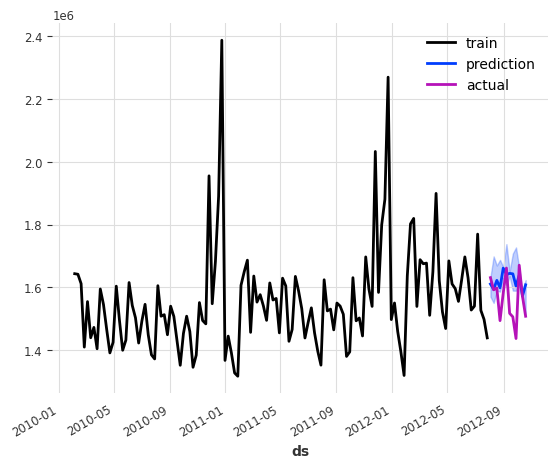

In [20]:
plotQuantile()